# Mental Health Analysis using NLP

## Project Overview

This notebook analyzes mental health statements using Natural Language Processing (NLP) techniques. We will:

1. **Explore the dataset** - Understanding the distribution of mental health conditions
2. **Preprocess text data** - Clean, tokenize, and transform text for machine learning
3. **Feature engineering** - Extract meaningful features from text and metadata
4. **Model training** - Train multiple classifiers to predict mental health conditions
5. **Evaluation** - Compare model performance and visualize results

The goal is to build a robust classification system that can identify different mental health conditions from textual statements.

## 1. Importing Required Libraries

We start by importing all necessary libraries for our analysis:

- **Data manipulation**: pandas, numpy
- **Visualization**: matplotlib, seaborn, wordcloud
- **Text processing**: nltk, regex
- **Machine learning**: scikit-learn, xgboost
- **Utility**: warnings, random, pickle for model saving

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Text processing
import re
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Machine learning
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization tools
from wordcloud import WordCloud

# Utilities
import warnings
import pickle
import os
warnings.filterwarnings("ignore")

# Create directories if they don't exist
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [2]:
df = pd.read_csv('data/mental_health.csv', index_col=0)

## 2. Data Loading and Exploration

Loading our mental health dataset to understand the structure and distribution of the data.

In [3]:
df.shape

(53044, 2)

In [4]:
df.head()  # Display the first few rows of the dataframe

,statement,status
0.0,oh my gosh,Anxiety
1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3.0,I've shifted my focus to something else but I'...,Anxiety
4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.info()  # Get a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 53044 entries, 0.0 to 53042.0
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

statement    363
status         1
dtype: int64

In [7]:
df.dropna(inplace=True)  # Drop rows with any missing values

In [8]:
df.isnull().sum()  # Check again for missing values after dropping  

statement    0
status       0
dtype: int64

In [9]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

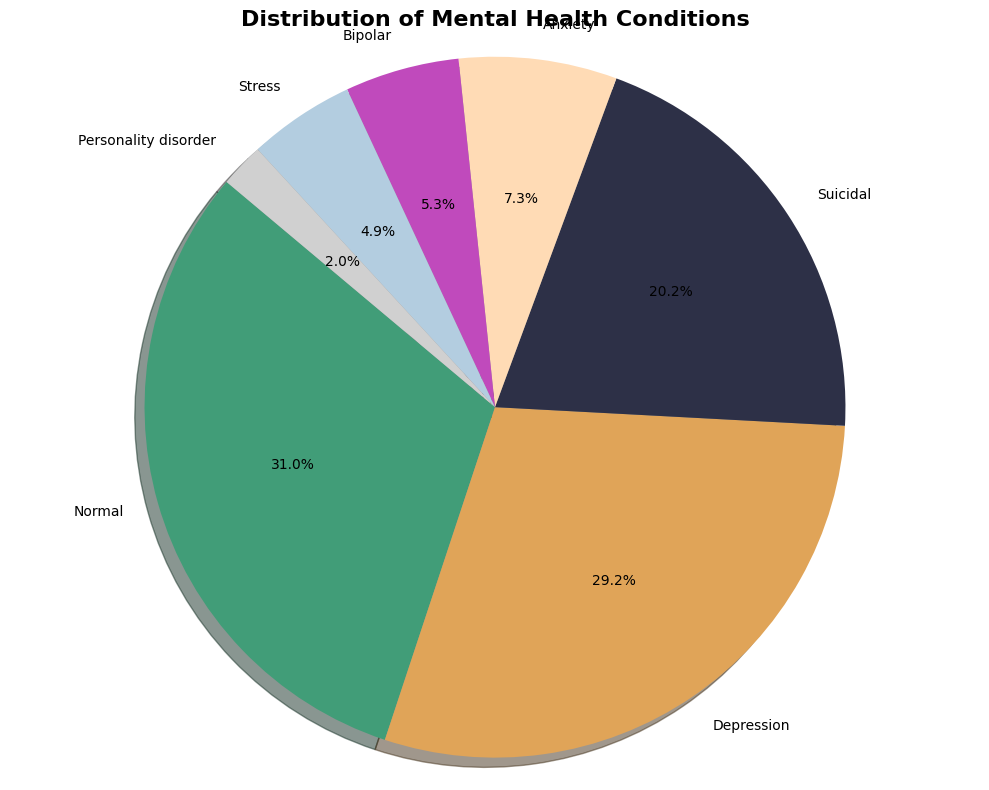

Dataset contains 52681 samples across 7 mental health categories


In [10]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Save the plot
plt.savefig('plots/mental_health_distribution.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

print(f"Dataset contains {len(df)} samples across {len(status_counts)} mental health categories")

In [11]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Worried about my stomach Started last night. I was drying clothes and I felt my stomach balloon up with gas so bad that I couldn’t stand. It wasn’t painful just uncomfortable. I started to panic. I went upstairs to my bedroom and took antacids because it’s all I had. Then I had to use the bathroom. I was still in panic mode as I could barely take a deep breath. It eventually went away but here I am sitting at work and my stomach is swelling up again and I’m scared it’s going to kill me. I just took a gas pill about 10 mins ago but it’s not working and I’m drinking water. It’s so uncomfortable it feels like I’m pregnant probably looks like it too. Can you die from having gas in your stomach like this? My anxiety is making it worse 

Status: Bipolar
Statement: Can hardly afford medication I was recently switched from Latuda (which was free with my insurance) I was switched to lurasidone for some reason and it’s 100.00. There’s no way I can actually afford this 

### Sample Analysis

Let's examine random samples from each mental health category to understand the nature of statements.

## 3. Text Preprocessing

Text preprocessing is crucial for NLP tasks. We will:

1. **Calculate text statistics** - Character count, sentence count
2. **Clean text** - Remove URLs, special characters, convert to lowercase
3. **Remove stopwords** - Eliminate common words that don't add meaning
4. **Lemmatization** - Reduce words to their root form
5. **Tokenization** - Split text into individual words
6. **Stemming** - Further reduce words to their stems

In [12]:
df.statement

0.0                                               oh my gosh
1.0        trouble sleeping, confused mind, restless hear...
2.0        All wrong, back off dear, forward doubt. Stay ...
3.0        I've shifted my focus to something else but I'...
4.0        I'm restless and restless, it's been a month n...
                                 ...                        
53038.0    Nobody takes me seriously I’ve (24M) dealt wit...
53039.0    selfishness  "I don't feel very good, it's lik...
53040.0    Is there any way to sleep better? I can't slee...
53041.0    Public speaking tips? Hi, all. I have to give ...
53042.0    I have really bad door anxiety! It's not about...
Name: statement, Length: 52681, dtype: object

Text Statistics:
       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.075625          6.256013
std           834.586377          9.187292
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         27588.000000        430.000000


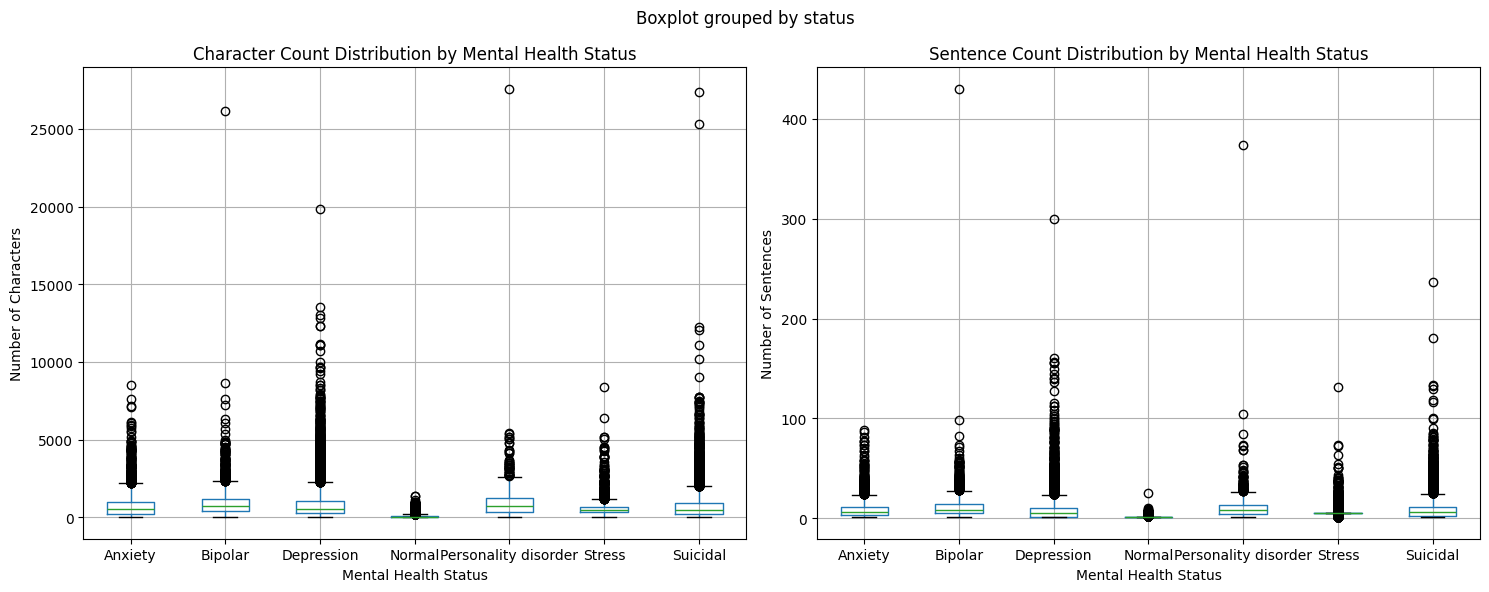

In [13]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()
print("Text Statistics:")
print(description)

# Visualize text statistics by mental health status
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Character count distribution
df.boxplot(column='num_of_characters', by='status', ax=axes[0])
axes[0].set_title('Character Count Distribution by Mental Health Status')
axes[0].set_xlabel('Mental Health Status')
axes[0].set_ylabel('Number of Characters')

# Sentence count distribution
df.boxplot(column='num_of_sentences', by='status', ax=axes[1])
axes[1].set_title('Sentence Count Distribution by Mental Health Status')
axes[1].set_xlabel('Mental Health Status')
axes[1].set_ylabel('Number of Sentences')

plt.tight_layout()
plt.savefig('plots/text_statistics_by_status.png', dpi=300, bbox_inches='tight')
plt.show()

### Text Statistics

First, let's analyze the length and structure of our text data.

In [14]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Load English stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
print(f"Loaded {len(stopwords)} stopwords for filtering")

Loaded 198 stopwords for filtering


### Text Cleaning and Preprocessing

Now we'll clean the text data by removing noise and preparing it for analysis.

In [15]:
def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)
     # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
     # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [16]:
# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(text_preprocessing)
df.head()

,statement,status,num_of_characters,num_of_sentences
0.0,oh gosh,Anxiety,10,1
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2
3.0,ive shifted focus something else im still worried,Anxiety,61,1
4.0,im restless restless month boy mean,Anxiety,72,2


In [ ]:
# Download WordNet data (required for lemmatization)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("WordNet lemmatizer ready!")
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

WordNet lemmatizer ready!


### Lemmatization

Lemmatization reduces words to their dictionary form (lemma). This helps in standardizing different forms of the same word.

In [18]:
## Apply lemmatization
df['statement'] = df['statement'].apply(lambda x: lemmatizer.lemmatize(x))

In [19]:
df.head()

,statement,status,num_of_characters,num_of_sentences
0.0,oh gosh,Anxiety,10,1
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2
3.0,ive shifted focus something else im still worried,Anxiety,61,1
4.0,im restless restless month boy mean,Anxiety,72,2


In [20]:
## Tokenization

# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,statement,status,num_of_characters,num_of_sentences,tokens
0.0,oh gosh,Anxiety,10,1,"[oh, gosh]"
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ..."
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2,"[wrong, back, dear, forward, doubt, stay, rest..."
3.0,ive shifted focus something else im still worried,Anxiety,61,1,"[ive, shifted, focus, something, else, im, sti..."
4.0,im restless restless month boy mean,Anxiety,72,2,"[im, restless, restless, month, boy, mean]"


### Tokenization and Stemming

Tokenization splits text into individual words, while stemming reduces words to their root form.

In [21]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed
0.0,oh gosh,Anxiety,10,1,"[oh, gosh]",oh gosh
1.0,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart tune
2.0,wrong back dear forward doubt stay restless re...,Anxiety,78,2,"[wrong, back, dear, forward, doubt, stay, rest...",wrong back dear forward doubt stay restless re...
3.0,ive shifted focus something else im still worried,Anxiety,61,1,"[ive, shifted, focus, something, else, im, sti...",ive shift focu someth els im still worri
4.0,im restless restless month boy mean,Anxiety,72,2,"[im, restless, restless, month, boy, mean]",im restless restless month boy mean


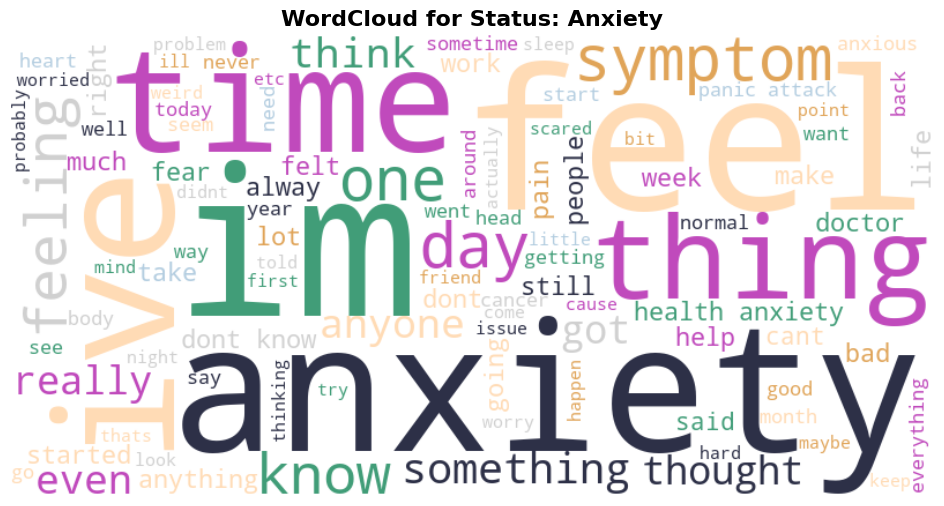

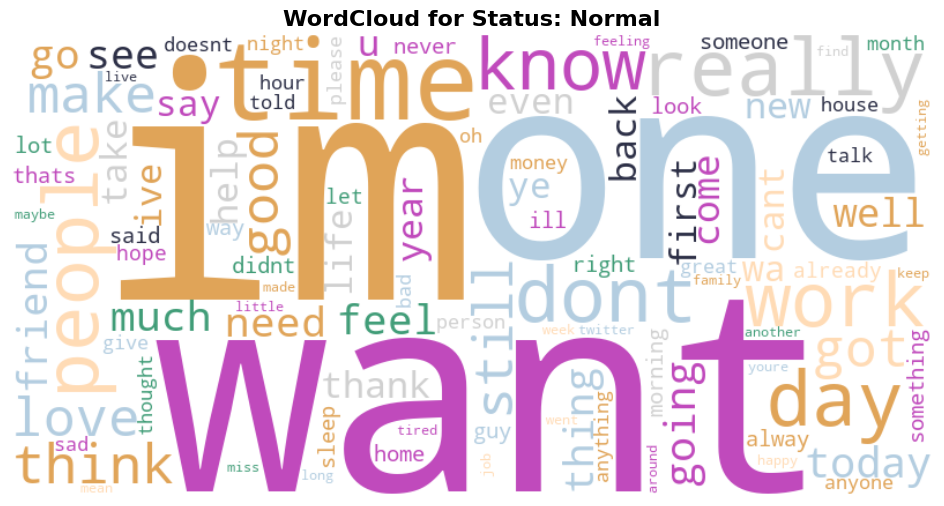

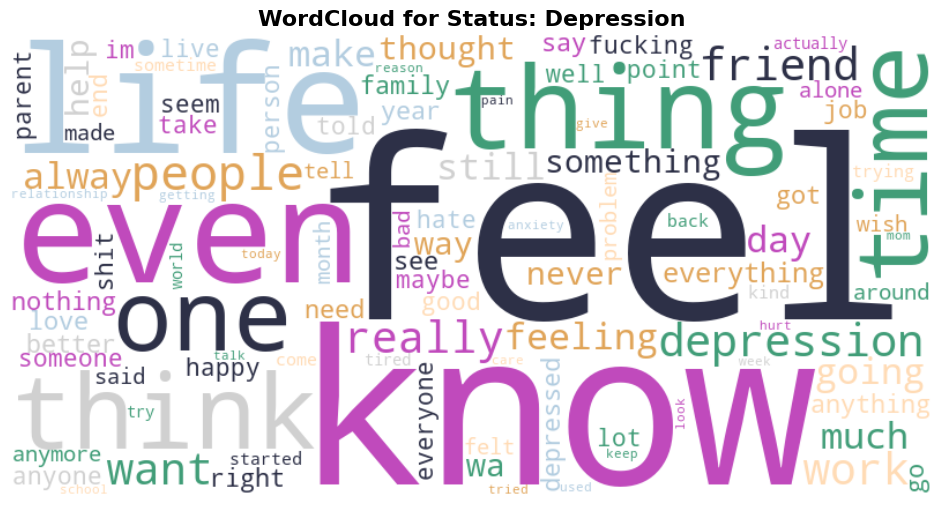

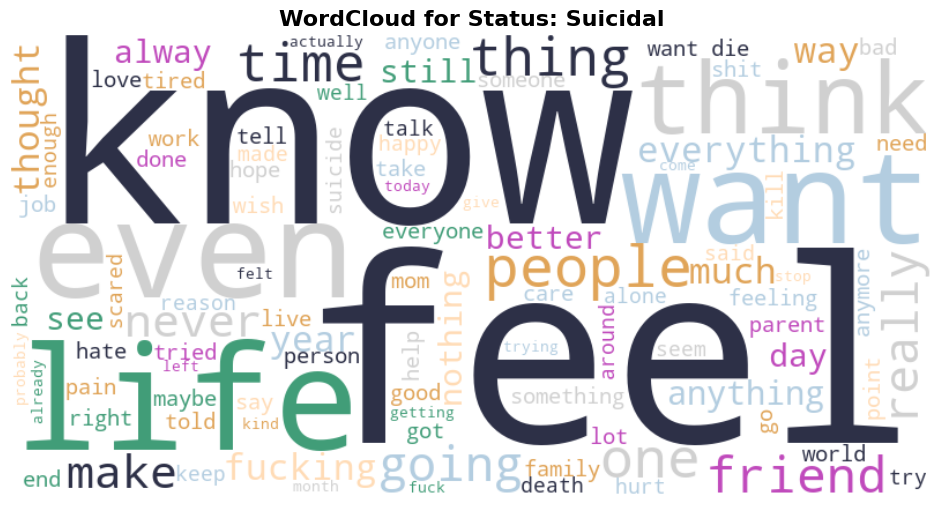

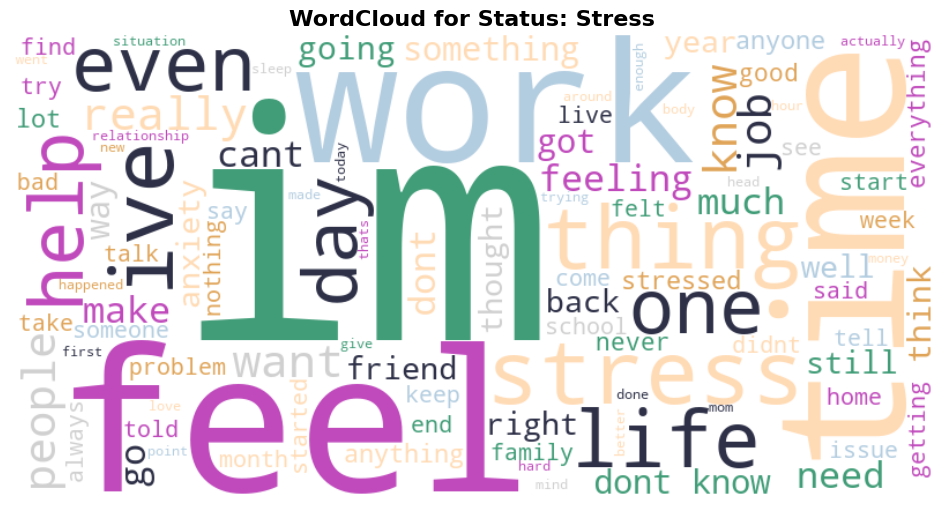

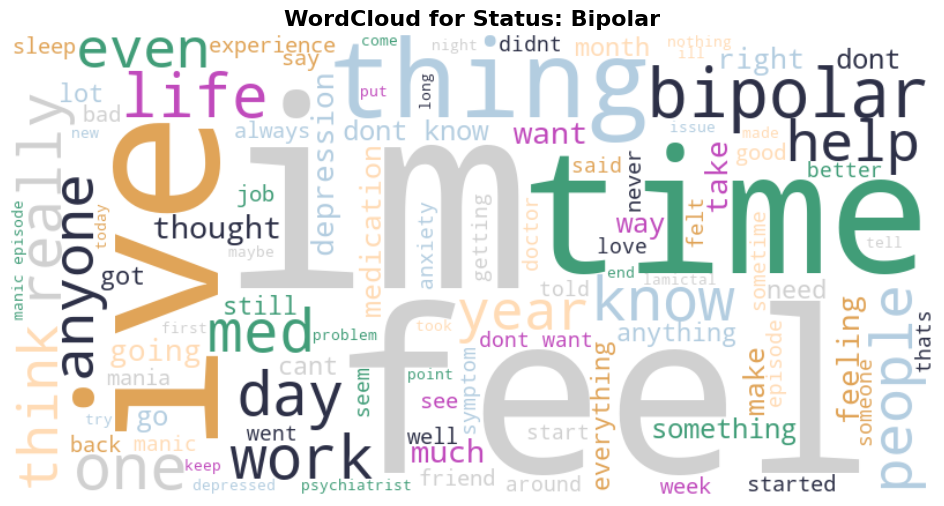

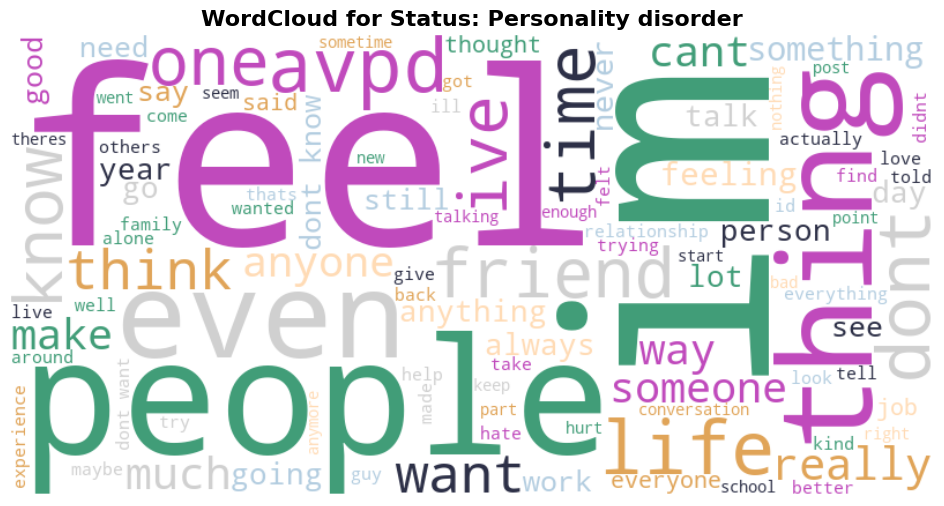

In [22]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for i, status in enumerate(statuses):
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         color_func=color_func, max_words=100).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}', fontsize=16, fontweight='bold')
    
    # Save the plot
    safe_filename = status.replace(' ', '_').replace('/', '_')
    plt.savefig(f'plots/wordcloud_{safe_filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Word Cloud Visualization

Word clouds help visualize the most frequent words in each mental health category.

## 4. Feature Engineering and Data Preparation

Now we prepare our features for machine learning:

1. **Feature selection** - Choose relevant features (text and numerical)
2. **Label encoding** - Convert categorical targets to numerical
3. **Train-test split** - Divide data for training and testing
4. **TF-IDF vectorization** - Convert text to numerical features
5. **Feature combination** - Merge text and numerical features

In [23]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [24]:
# Encode target labels
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

# Save the label encoder for later use
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(lbl_enc, f)

print(f'Target classes: {lbl_enc.classes_}')
print(f'Label encoder saved to models/label_encoder.pkl')

Target classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Label encoder saved to models/label_encoder.pkl


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [26]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print(f'Number of feature words: {len(vectorizer.get_feature_names_out())}')
print(f'Total features (text + numerical): {X_train_combined.shape[1]}')

# Save the vectorizer for later use
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print('TF-IDF vectorizer saved to models/tfidf_vectorizer.pkl')

Number of feature words: 50000
Total features (text + numerical): 50002
TF-IDF vectorizer saved to models/tfidf_vectorizer.pkl


In [27]:
y_train

array([2, 3, 2, ..., 1, 2, 3])

## 5. Model Training and Evaluation

We'll train multiple machine learning models to find the best performer:

- **Bernoulli Naive Bayes**: Probabilistic classifier good for binary features
- **Decision Tree**: Interpretable tree-based model
- **Logistic Regression**: Linear model with regularization
- **K-Nearest Neighbors**: Instance-based learning algorithm

Each model will be evaluated using accuracy, confusion matrix, and classification report.

In [28]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
     'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
     'KNN': KNeighborsClassifier(n_neighbors=5),
    # 'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_split=5, random_state=101),
    # 'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')
}


Training Bernoulli Naive Bayes...
Accuracy: 0.6538

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.72      0.62      0.67       768
             Bipolar       0.72      0.61      0.66       556
          Depression       0.71      0.48      0.57      3081
              Normal       0.67      0.93      0.78      3269
Personality disorder       0.64      0.53      0.58       215
              Stress       0.44      0.56      0.49       517
            Suicidal       0.59      0.54      0.56      2131

            accuracy                           0.65     10537
           macro avg       0.64      0.61      0.62     10537
        weighted avg       0.66      0.65      0.64     10537

Accuracy: 0.6538

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.72      0.62      0.67       768
             Bipolar       0.72      0.61      0.66       556
          D

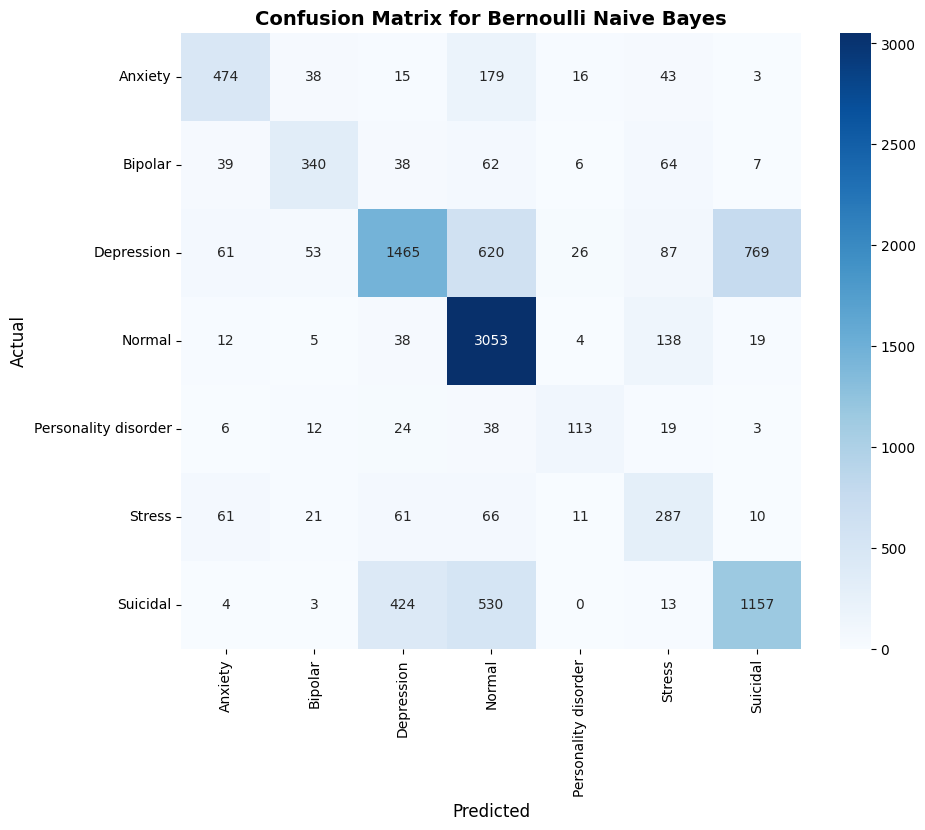


Training Decision Tree...
Accuracy: 0.6753

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.60      0.59      0.59       768
             Bipolar       0.67      0.43      0.53       556
          Depression       0.67      0.69      0.68      3081
              Normal       0.77      0.92      0.84      3269
Personality disorder       0.54      0.32      0.40       215
              Stress       0.51      0.39      0.44       517
            Suicidal       0.55      0.48      0.52      2131

            accuracy                           0.68     10537
           macro avg       0.62      0.55      0.57     10537
        weighted avg       0.66      0.68      0.66     10537

Accuracy: 0.6753

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.60      0.59      0.59       768
             Bipolar       0.67      0.43      0.53       556
          Depressio

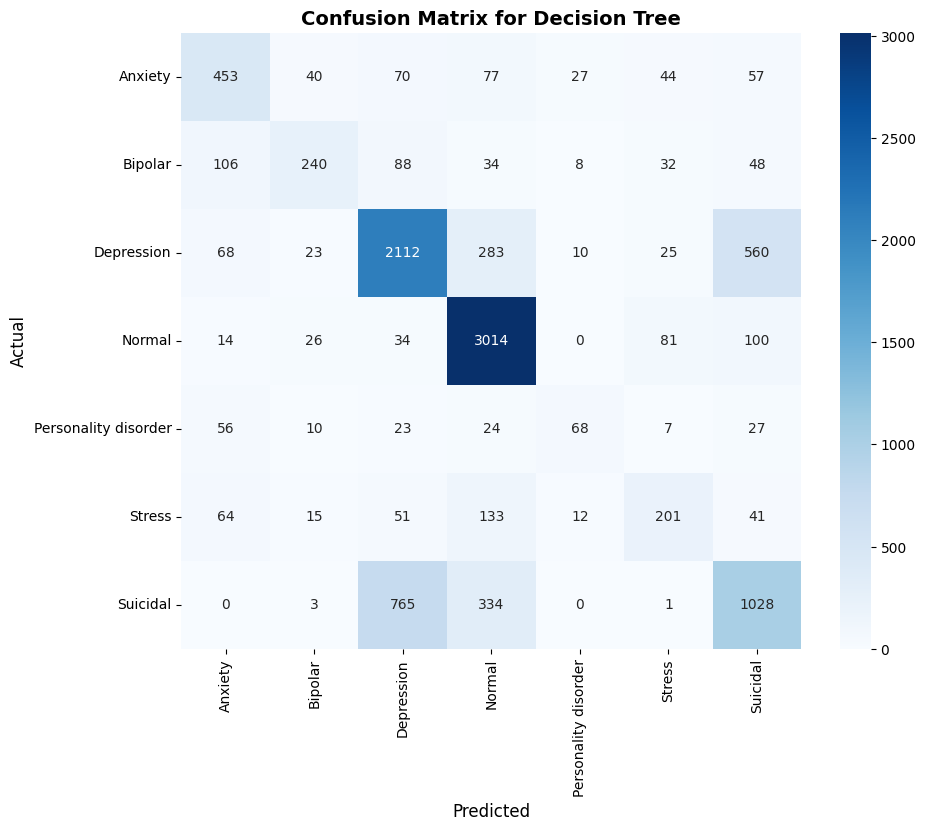


Training Logistic Regression...
Accuracy: 0.7541

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       768
             Bipolar       0.85      0.81      0.83       556
          Depression       0.70      0.70      0.70      3081
              Normal       0.86      0.92      0.89      3269
Personality disorder       0.79      0.68      0.73       215
              Stress       0.63      0.53      0.58       517
            Suicidal       0.64      0.61      0.62      2131

            accuracy                           0.75     10537
           macro avg       0.75      0.72      0.73     10537
        weighted avg       0.75      0.75      0.75     10537

Accuracy: 0.7541

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       768
             Bipolar       0.85      0.81      0.83       556
          Dep

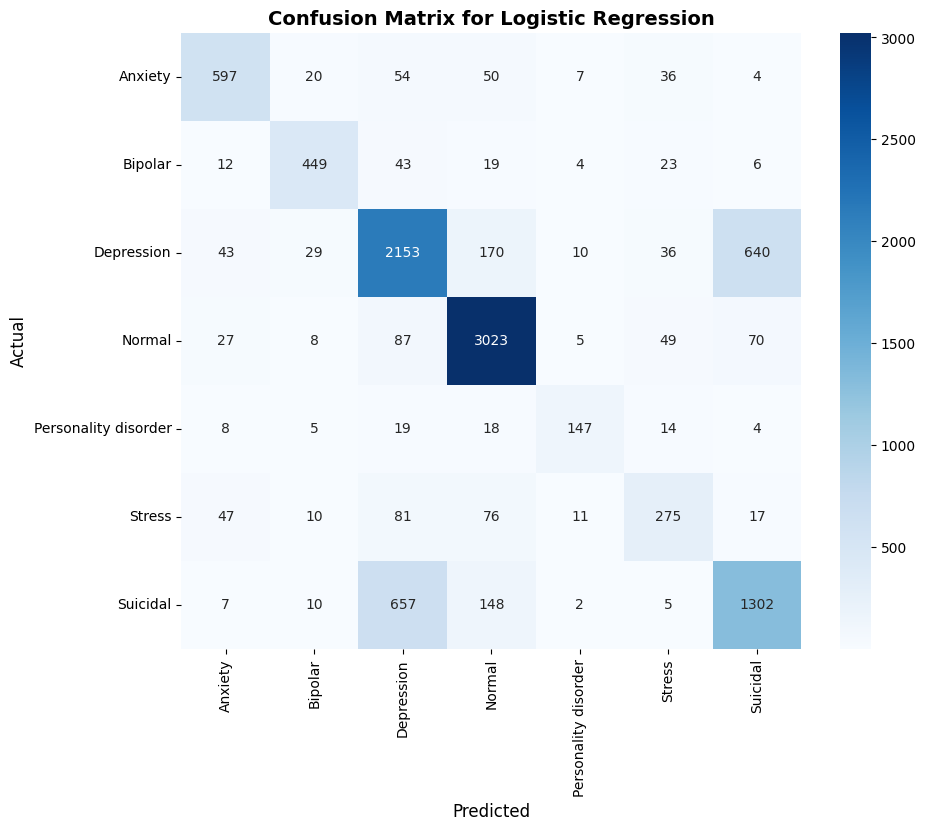


Training KNN...
Accuracy: 0.5155

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.20      0.16      0.18       768
             Bipolar       0.17      0.14      0.15       556
          Depression       0.47      0.59      0.52      3081
              Normal       0.77      0.85      0.81      3269
Personality disorder       0.10      0.05      0.06       215
              Stress       0.29      0.26      0.28       517
            Suicidal       0.34      0.23      0.27      2131

            accuracy                           0.52     10537
           macro avg       0.33      0.33      0.32     10537
        weighted avg       0.49      0.52      0.49     10537

Accuracy: 0.5155

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.20      0.16      0.18       768
             Bipolar       0.17      0.14      0.15       556
          Depression       0.

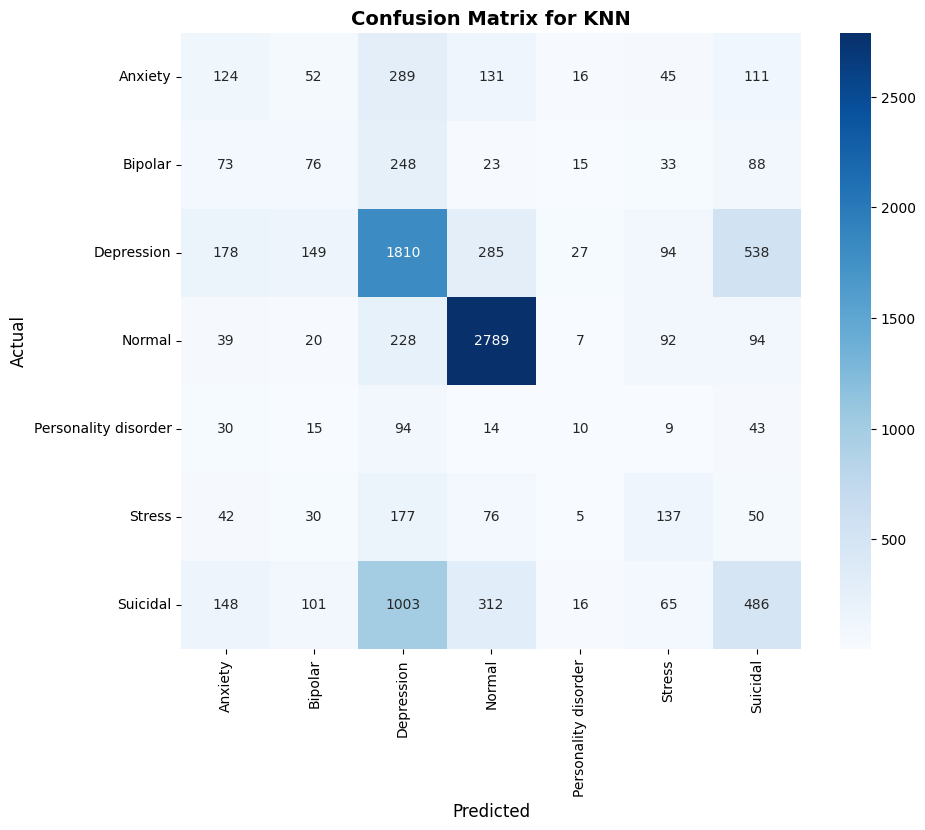


All models trained successfully!
Best model (Logistic Regression) saved as models/training_model.pkl
Best accuracy: 0.7541


In [29]:
# Initialize a list to store accuracy scores and model results
accuracy_scores = []
model_results = {}

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    # Train the model
    clf.fit(X_train_combined, y_train)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    
    # Store results
    model_results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'Confusion Matrix for {name}', fontsize=14, fontweight='bold')
    
    # Save the confusion matrix plot
    safe_name = name.replace(' ', '_').lower()
    plt.savefig(f'plots/confusion_matrix_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

# Find the best performing model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
best_model = model_results[best_model_name]['model']
best_accuracy = model_results[best_model_name]['accuracy']

# Save only the best performing model
with open('models/training_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n{'='*50}")
print("All models trained successfully!")
print(f"Best model ({best_model_name}) saved as models/training_model.pkl")
print(f"Best accuracy: {best_accuracy:.4f}")
print(f"{'='*50}")

Model Performance Summary:
           Classifier  Accuracy
  Logistic Regression  0.754105
        Decision Tree  0.675335
Bernoulli Naive Bayes  0.653791
                  KNN  0.515517


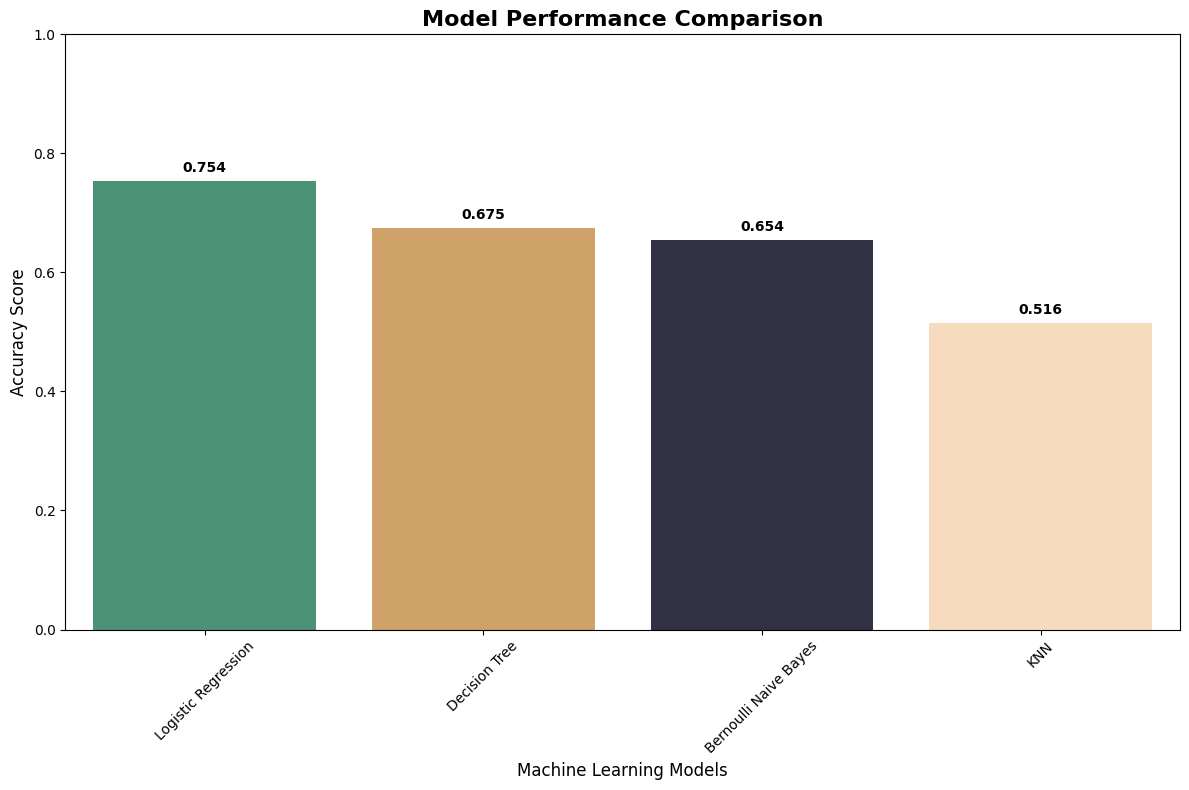


Best performing model: Logistic Regression with accuracy: 0.7541


In [30]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({
    'Classifier': list(classifiers.keys()), 
    'Accuracy': accuracy_scores
}).sort_values('Accuracy', ascending=False)

print("Model Performance Summary:")
print(accuracies_df.to_string(index=False))

# Create visualization
plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:len(accuracies_df)]))

# Create a bar plot to visualize the accuracy of each classifier
ax = sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

# Add value labels on top of bars
for i, v in enumerate(accuracies_df['Accuracy']):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Machine Learning Models', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Save the plot
plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the best model information
best_model_name = accuracies_df.iloc[0]['Classifier']
best_accuracy = accuracies_df.iloc[0]['Accuracy']
print(f"\nBest performing model: {best_model_name} with accuracy: {best_accuracy:.4f}")

In [31]:
## Summary and Model Deployment Preparation

# Save preprocessing functions and parameters for deployment
preprocessing_pipeline = {
    'stemmer': stemmer,
    'lemmatizer': lemmatizer,
    'stopwords': stopwords
}

with open('models/preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)

# Save best model information
best_model_info = {
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'all_accuracies': dict(zip(classifiers.keys(), accuracy_scores))
}

with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(best_model_info, f)

print("Analysis Complete! 🎉")
print("\nFiles saved:")
print("📊 Plots saved in 'plots/' folder")
print("🤖 Best model saved as 'training_model.pkl'")
print("🔧 Preprocessing pipeline saved")
print("📋 Model information saved")

print(f"\nDataset: {len(df)} samples across {len(df['status'].unique())} categories")
print(f"Best model: {best_model_name} ({best_accuracy:.4f} accuracy)")
print(f"Total features: {X_train_combined.shape[1]} (TF-IDF + numerical)")

print("\nReady for Streamlit app deployment! 🚀")

Analysis Complete! 🎉

Files saved:
📊 Plots saved in 'plots/' folder
🤖 Best model saved as 'training_model.pkl'
🔧 Preprocessing pipeline saved
📋 Model information saved

Dataset: 52681 samples across 7 categories
Best model: Logistic Regression (0.7541 accuracy)
Total features: 50002 (TF-IDF + numerical)

Ready for Streamlit app deployment! 🚀
